# Hashing

In [1]:
import qiskit

from qiskit.providers.fake_provider import FakeBackend5QV2
from qiskit.providers.fake_provider import FakeLimaV2
from qiskit.providers.fake_provider import FakeMontrealV2
from qiskit.providers.fake_provider import FakeGuadalupeV2
from qiskit.providers.fake_provider import FakeBoeblingenV2

%cd ../transpiler

from qml_transpiler import get_circuit_hash

from qml_transpiler import get_litmus_circuit
from qml_transpiler import transpile

/mnt/c/Users/mohor/Jupyter/Haiqu/transpiler


In [2]:
# Backend

FAKE_BACKEND = FakeBackend5QV2()
# FAKE_BACKEND = FakeLimaV2()
# FAKE_BACKEND = FakeGuadalupeV2()
# FAKE_BACKEND = FakeBoeblingenV2()
# FAKE_BACKEND = FakeMontrealV2()

backend = qiskit.providers.aer.AerSimulator.from_backend(FAKE_BACKEND)

# backend.options.noise_model = None

# qiskit.visualization.plot_gate_map(FAKE_BACKEND)

In [3]:
# Circuit

QUBITS_COUNT = 3

litmus_circuit = get_litmus_circuit(QUBITS_COUNT, "Litmus")

### Compare Simple Hashes

In [4]:
xh_circuit = qiskit.QuantumCircuit(2)

xh_circuit.x(0)
xh_circuit.h(1)

xh_circuit.draw()

get_circuit_hash(xh_circuit)

'7a671ed73e8c6f8e7d46919e3ebc2a42249c26bb0d8f269d09c84cd705e2cf4d'

In [5]:
hx_circuit = qiskit.QuantumCircuit(2)

hx_circuit.h(1)
hx_circuit.x(0)

hx_circuit.draw()

get_circuit_hash(hx_circuit)

'7a671ed73e8c6f8e7d46919e3ebc2a42249c26bb0d8f269d09c84cd705e2cf4d'

### Compare Parameters Hashes

In [6]:
def bind_parameters_with_offset(circuit, offset=0):

    bound_circuit = circuit.copy()

    for index, parameter in enumerate(bound_circuit.parameters):

        bound_circuit.assign_parameters(
            {parameter: index + offset},
            inplace=True)

    return bound_circuit

In [7]:
# Bound Circuits

bound_circuit = bind_parameters_with_offset(litmus_circuit, offset=0)
bound_circuit_same_parameters = bind_parameters_with_offset(litmus_circuit, offset=0)
bound_circuit_other_parameters = bind_parameters_with_offset(litmus_circuit, offset=1)

# Hashes

circuit_hash = get_circuit_hash(bound_circuit)
circuit_same_parameters_hash = get_circuit_hash(bound_circuit_same_parameters)
circuit_other_parameters_hash = get_circuit_hash(bound_circuit_other_parameters)

In [8]:
# Display Circuits

display(bound_circuit.draw(fold=-1))
display(bound_circuit_same_parameters.draw(fold=-1))
display(bound_circuit_other_parameters.draw(fold=-1))

┌───────┐          ┌───┐ Litmus 
Litmus_0_0: ┤ Rz(0) ├──■───────┤ X ├───░────
            ├───────┤┌─┴─┐     └─┬─┘   ░    
Litmus_0_1: ┤ Rz(1) ├┤ X ├──■────┼─────░────
            ├───────┤└───┘┌─┴─┐  │     ░    
Litmus_0_2: ┤ Rz(2) ├─────┤ X ├──■─────░────
            └───────┘     └───┘        ░

┌───────┐          ┌───┐ Litmus 
Litmus_0_0: ┤ Rz(0) ├──■───────┤ X ├───░────
            ├───────┤┌─┴─┐     └─┬─┘   ░    
Litmus_0_1: ┤ Rz(1) ├┤ X ├──■────┼─────░────
            ├───────┤└───┘┌─┴─┐  │     ░    
Litmus_0_2: ┤ Rz(2) ├─────┤ X ├──■─────░────
            └───────┘     └───┘        ░

┌───────┐          ┌───┐ Litmus 
Litmus_0_0: ┤ Rz(1) ├──■───────┤ X ├───░────
            ├───────┤┌─┴─┐     └─┬─┘   ░    
Litmus_0_1: ┤ Rz(2) ├┤ X ├──■────┼─────░────
            ├───────┤└───┘┌─┴─┐  │     ░    
Litmus_0_2: ┤ Rz(3) ├─────┤ X ├──■─────░────
            └───────┘     └───┘        ░

In [9]:
# Display Hashes

display(get_circuit_hash(bound_circuit))
display(get_circuit_hash(bound_circuit_same_parameters))
display(get_circuit_hash(bound_circuit_other_parameters))

'ad0ae12840c8d2786a60c336e5c4224ea6097bed4c71073445dbe14230d0430a'

'ad0ae12840c8d2786a60c336e5c4224ea6097bed4c71073445dbe14230d0430a'

'9b9b1f5165eeda17d387a9ca24626dce92a9548cb0a8edb4028264194571a9a5'

### Compare Structure Hashes

In [9]:
# Circuits

transpiled_litmus_circuit = transpile(
    litmus_circuit, 
    backend,
    # optimization_level=3,
    # initial_layout=[1, 2, 3],
    seed_transpiler=1234,
)

transpiled_litmus_circuit_same_seed = transpile(
    litmus_circuit, 
    backend,
    # optimization_level=3,
    # initial_layout=[1, 2, 3],
    seed_transpiler=1234,
)

transpiled_litmus_circuit_other_seed = transpile(
    litmus_circuit, 
    backend,
    # optimization_level=3,
    # initial_layout=[1, 2, 3],
    seed_transpiler=777,
)

In [10]:
# Display Circuits

display(transpiled_litmus_circuit.draw(fold=-1))
display(transpiled_litmus_circuit_same_seed.draw(fold=-1))
display(transpiled_litmus_circuit_other_seed.draw(fold=-1))

global phase: -0.5*Litmus_0 - 0.5*Litmus_1 - 0.5*Litmus_2
                                                                    
 ancilla_0 -> 0 ────────────────────────────────────────────────────
                ┌─────────────────┐          ┌───┐          ┌───┐ ░ 
Litmus_0_2 -> 1 ┤ U(0,0,Litmus_2) ├───────■──┤ X ├──■───────┤ X ├─░─
                ├─────────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘ ░ 
Litmus_0_0 -> 2 ┤ U(0,0,Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■───░─
                ├─────────────────┤┌─┴─┐└───┘     └───┘└─┬─┘      ░ 
Litmus_0_1 -> 3 ┤ U(0,0,Litmus_1) ├┤ X ├─────────────────■────────░─
                └─────────────────┘└───┘                          ░ 
 ancilla_1 -> 4 ────────────────────────────────────────────────────

global phase: -0.5*Litmus_0 - 0.5*Litmus_1 - 0.5*Litmus_2
                                                                    
 ancilla_0 -> 0 ────────────────────────────────────────────────────
                ┌─────────────────┐          ┌───┐          ┌───┐ ░ 
Litmus_0_2 -> 1 ┤ U(0,0,Litmus_2) ├───────■──┤ X ├──■───────┤ X ├─░─
                ├─────────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘ ░ 
Litmus_0_0 -> 2 ┤ U(0,0,Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■───░─
                ├─────────────────┤┌─┴─┐└───┘     └───┘└─┬─┘      ░ 
Litmus_0_1 -> 3 ┤ U(0,0,Litmus_1) ├┤ X ├─────────────────■────────░─
                └─────────────────┘└───┘                          ░ 
 ancilla_1 -> 4 ────────────────────────────────────────────────────

global phase: -0.5*Litmus_0 - 0.5*Litmus_1 - 0.5*Litmus_2
                                                                    
 ancilla_0 -> 0 ────────────────────────────────────────────────────
                ┌─────────────────┐               ┌───┐           ░ 
Litmus_0_0 -> 1 ┤ U(0,0,Litmus_0) ├──■─────────■──┤ X ├──■────────░─
                ├─────────────────┤┌─┴─┐     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐ ░ 
Litmus_0_1 -> 2 ┤ U(0,0,Litmus_1) ├┤ X ├──■──┤ X ├──■──┤ X ├┤ X ├─░─
                ├─────────────────┤└───┘┌─┴─┐└───┘     └───┘└─┬─┘ ░ 
Litmus_0_2 -> 3 ┤ U(0,0,Litmus_2) ├─────┤ X ├─────────────────■───░─
                └─────────────────┘     └───┘                     ░ 
 ancilla_1 -> 4 ────────────────────────────────────────────────────

In [11]:
# Display Hashes

display(get_circuit_hash(transpiled_litmus_circuit))
display(get_circuit_hash(transpiled_litmus_circuit_same_seed))
display(get_circuit_hash(transpiled_litmus_circuit_other_seed))

'37d19a8f9144a8b7a5cb2fb1107944c154e8f480291811b7c00391b513060e05'

'37d19a8f9144a8b7a5cb2fb1107944c154e8f480291811b7c00391b513060e05'

'a9e4bd68e7210487dd984f32b5038b0687911aeaea290592b28a4aec05c987b2'

# Benchmark

In [12]:
from time import time
from matplotlib import pyplot as plt

plt.style.use("dark_background")

In [13]:
QUBITS_COUNT = 100
MAX_LAYERS_COUNT = 5

GATES = ['x', 'y', 'z',
         'rx', 'ry', 'rz',
         'rxx', 'ryy', 'rzz',
         'swap', 'i']

gates_counts = []
layers_counts = []
elapsed_times = []

for layers_count in range(MAX_LAYERS_COUNT):

    circuit = qiskit.circuit.library.EfficientSU2(QUBITS_COUNT, 
                                                  reps=layers_count,
                                                  su2_gates=GATES,
                                                  entanglement="circular",
                                                  skip_final_rotation_layer=True)


    circuit_decomposed = circuit.decompose(None, 1)

    gates_count = len(circuit_decomposed.data)
    
    print("gates_count:", gates_count)
    
    start_time = time()
    
    circuit_hash = get_circuit_hash(circuit_decomposed)
    
    elapsed_time = time() - start_time
    
    gates_counts.append(gates_count)
    layers_counts.append(layers_count)
    elapsed_times.append(elapsed_time)
    
    print(f"elapsed_time:{elapsed_time:.5f}")

    # circuit_decomposed.draw(fold=-1)

gates_count: 0
elapsed_time:0.00131
gates_count: 1000
elapsed_time:0.01582
gates_count: 2000
elapsed_time:0.04081
gates_count: 3000
elapsed_time:0.04587
gates_count: 4000
elapsed_time:0.06630


# Plots

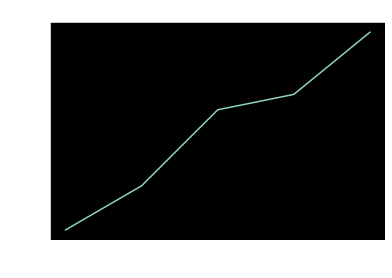

In [14]:
plt.title("Hashing Time")

plt.xlabel("Gates count")
plt.ylabel("Time, seconds")

plt.plot(gates_counts, elapsed_times);

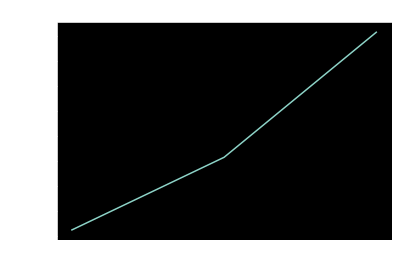

In [15]:
plt.title("Hashing Time")

plt.xlabel("Gates count")
plt.ylabel("Time, seconds")

plt.plot(gates_counts[:3], elapsed_times[:3]);

In [16]:
# %%timeit -r 10 -n 100

# get_circuit_hash(circuit)

In [17]:
%%timeit -r 1 -n 1

get_circuit_hash(circuit_decomposed)

66.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
